# Sentiment analysis on movie reviews

It is based on this notebook with some modification/explanation:

https://www.kaggle.com/code/nilanml/imdb-review-deep-model-94-89-accuracy

In [1]:
import zipfile as zf
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
pd.set_option('display.max_colwidth', 255)

# data cleaning
import re
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

# Keras modules
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense , Input , LSTM , Embedding, Dropout , Activation, GRU, Flatten
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model, Sequential
from keras.layers import Convolution1D
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.callbacks import ReduceLROnPlateau

from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt


In [2]:
zips = ['/kaggle/input/word2vec-nlp-tutorial/labeledTrainData.tsv.zip',
       '/kaggle/input/word2vec-nlp-tutorial/testData.tsv.zip',
       '/kaggle/input/word2vec-nlp-tutorial/unlabeledTrainData.tsv.zip']

for z in zips:
    with zf.ZipFile(z, 'r') as zip_ref:
        zip_ref.extractall('/kaggle/working/')

In [3]:
train_df = pd.read_csv('/kaggle/working/labeledTrainData.tsv', delimiter="\t")
train_df.head()

,id,sentiment,review
0,5814_8,1,"With all this stuff going down at the moment with MJ i've started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought..."
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hines is a very entertaining film that obviously goes to great effort and lengths to faithfully recreate H. G. Wells' classic book. Mr. Hines succeeds in doing so. I, and those who watched his film with me, ..."
2,7759_3,0,"The film starts with a manager (Nicholas Bell) giving welcome investors (Robert Carradine) to Primal Park . A secret project mutating a primal animal using fossilized DNA, like ¨Jurassik Park¨, and some scientists resurrect one of nature's most fearso..."
3,3630_4,0,"It must be assumed that those who praised this film (\the greatest filmed opera ever,\"" didn't I read somewhere?) either don't care for opera, don't care for Wagner, or don't care about anything except their desire to appear Cultured. Either as a repr..."
4,9495_8,1,"Superbly trashy and wondrously unpretentious 80's exploitation, hooray! The pre-credits opening sequences somewhat give the false impression that we're dealing with a serious and harrowing drama, but you need not fear because barely ten minutes later ..."


In [4]:
train_df['review'][9]

'<br /><br />This movie is full of references. Like \\Mad Max II\\", \\"The wild one\\" and many others. The ladybug´s face it´s a clear reference (or tribute) to Peter Lorre. This movie is a masterpiece. We´ll talk much more about in the future."'

In [5]:
train_df.describe()

,sentiment
count,25000.00000
mean,0.50000
std,0.50001
min,0.00000
25%,0.00000
50%,0.50000
75%,1.00000
max,1.00000


# Preprocessing

- lemmatisation: correctly identifying the intended part of speech and meaning of a word in a sentence. (e.g.: "better" has a lemma as "good")
- stopwords: list of words that are insignificant to the model

In [6]:
stop_words = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

def clean_text(text):
    # to get rid of html tags and make it lower case:
    text = BeautifulSoup(text, "html.parser").get_text().lower()   
    
    # to get rid of the unnecessary characters eg.: .;\/,*-#<>:()[]{}Łß@
    text = re.sub(r'[^a-z0-9\s]', '', text)    
    
    # lemmatize, remove stopwords
    # 2.param: part of speech tag, "v" for verbs
    text = [wnl.lemmatize(token, "n") for token in text.split(" ")]
    text = [wnl.lemmatize(token, "v") for token in text] 
    text = [word for word in text if not word in stop_words]
    text = " ".join(text)
    
    return text

train_df['processed_reviews'] = train_df.review.apply(lambda x: clean_text(x))


/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [7]:
train_df.processed_reviews[9]

'movie full reference like mad max ii wild one many others ladybug face clear reference tribute peter lorre movie masterpiece well talk much future'

# ML analysis

tokenization: substituting certain words with other abstract characters (identifiers), and mapping them back through this system. E.g. used in contraction of two words like: don't, won't.

In [8]:
max_features = 6000 
tokenizer = Tokenizer(num_words=max_features) # tokenization, num_words: maximum number of words to keep based on their frequency
tokenizer.fit_on_texts(train_df['processed_reviews'])
list_tokenized_train = tokenizer.texts_to_sequences(train_df['processed_reviews']) # convert each word into integers for the model usage

In [9]:
# each review has different length, so we need to deal with this
print(len(list_tokenized_train[1]), 
        len(list_tokenized_train[2]), 
        len(list_tokenized_train[3]),
        len(list_tokenized_train[221]))

78 178 143 97


In [10]:
# checking numerized form of reviews
list_tokenized_train[1][:5]

[241, 207, 99, 3156, 5916]

In the original notebook, only 130 (the mean) word per review is used.
I use the maximum value (1182) for each row of data, where the rest of spaces are filled with 0.
It makes the model a bit more complex, but dont seems like it would take much more runtime (GPU), and it will learn more words.


In [11]:
X_t = pad_sequences(list_tokenized_train) # creates a 2d np array for train data
y = train_df['sentiment'] # label

In [12]:
print(f"X shape: {X_t.shape}, y shape: {y.shape}")

X shape: (25000, 1121), y shape: (25000,)


In [13]:
X_t[1][1000:]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  241,
        207,   99, 3156, 5916,  276,    3,  449,   13,   31,  505, 1587,
       3373, 2715, 3374,   23,  241,  158,  303, 5916, 1119,   14,    3,
        727,  101,    2,  670,  627,  271, 1851,   40,   93,   55, 2592,
       2618,  190,  693, 2672, 3044, 3204,  158,  449,  229,   22,  189,
         41,    1, 1852,  971,   22, 2928,  202,  305,  838,    1,  562,
        276,   27,   52,  661,  971,  123,  505,  303, 5916,  141, 2289,
         23,  241,  466,   42,  276,    5,  665, 1828,  971, 4046, 4394],
      dtype=int32)

In [14]:
# train/validation split
x_train, x_val = X_t[:18000], X_t[18000:]
y_train, y_val = y[:18000], y[18000:]

In [15]:
model = Sequential()
model.add(Embedding(max_features, 64))
model.add(Bidirectional(LSTM(32, return_sequences = True)))
model.add(GlobalMaxPool1D())
model.add(Dense(20, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

2023-01-19 12:04:26.182935: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 12:04:26.285800: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 12:04:26.286640: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-19 12:04:26.288944: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          384000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 64)          24832     
_________________________________________________________________
global_max_pooling1d (Global (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                1300      
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 410,153
Trainable params: 410,153
Non-trainable params: 0
__________________________________________________

In [17]:
# Learning rate optimizer
LR_optim = ReduceLROnPlateau(monitor='val_acc', 
                             patience=2, # change after num of epochs 
                             verbose=1, # update messages
                             factor=0.5, # reduction on lr
                             min_lr=0.001)

In [18]:
batch_size = 100 
epochs = 4
model.fit(x_train, y_train,
          batch_size=batch_size, 
          epochs=epochs, 
          callbacks=[LR_optim],
          validation_data=(x_val, y_val))

Epoch 1/4


2023-01-19 12:04:29.827312: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2023-01-19 12:04:33.004785: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


180/180 [==============================] - 24s 108ms/step - loss: 0.5009 - accuracy: 0.7561 - val_loss: 0.3166 - val_accuracy: 0.8696
Epoch 2/4
180/180 [==============================] - 19s 106ms/step - loss: 0.2666 - accuracy: 0.9055 - val_loss: 0.2962 - val_accuracy: 0.8786
Epoch 3/4
180/180 [==============================] - 19s 104ms/step - loss: 0.2047 - accuracy: 0.9328 - val_loss: 0.3198 - val_accuracy: 0.8756
Epoch 4/4
180/180 [==============================] - 19s 105ms/step - loss: 0.1600 - accuracy: 0.9510 - val_loss: 0.3693 - val_accuracy: 0.8717


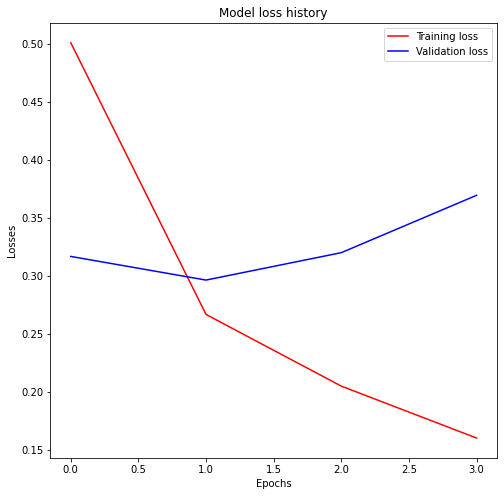

In [19]:
fig = plt.figure(figsize=(8,8))
plt.plot(model.history.history['loss'], 'r', label='Training loss')
plt.plot(model.history.history['val_loss'], 'b', label='Validation loss')
plt.title('Model loss history')
plt.ylabel('Losses')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# Test dataset prediction

In [20]:
test_df = pd.read_csv("/kaggle/working/testData.tsv",header=0, delimiter="\t", quoting=3)
test_df.head()

,id,review
0,"""12311_10""","""Naturally in a film who's main themes are of mortality, nostalgia, and loss of innocence it is perhaps not surprising that it is rated more highly by older viewers than younger ones. However there is a craftsmanship and completeness to the film which..."
1,"""8348_2""","""This movie is a disaster within a disaster film. It is full of great action scenes, which are only meaningful if you throw away all sense of reality. Let's see, word to the wise, lava burns you; steam burns you. You can't stand next to lava. Divertin..."
2,"""5828_4""","""All in all, this is a movie for kids. We saw it tonight and my child loved it. At one point my kid's excitement was so great that sitting was impossible. However, I am a great fan of A.A. Milne's books which are very subtle and hide a wry intelligenc..."
3,"""7186_2""","""Afraid of the Dark left me with the impression that several different screenplays were written, all too short for a feature length film, then spliced together clumsily into this Frankenstein's monster.<br /><br />At his best, the protagonist, Lucas, ..."
4,"""12128_7""","""A very accurate depiction of small time mob life filmed in New Jersey. The story, characters and script are believable but the acting drops the ball. Still, it's worth watching, especially for the strong images, some still with me even though I first..."


In [21]:
# apply cleaning on test
test_df["review"] = test_df.review.apply(lambda x: clean_text(x))
 
# extract and binarize id data as sentiment
test_df["sentiment"] = test_df["id"].map(lambda x: 1 if int(x.strip('"').split("_")[1]) >= 5 else 0)

y_test = test_df["sentiment"] # label

# tokenize, convert to numbers
list_sentences_test = test_df["review"]
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)
X_te = pad_sequences(list_tokenized_test) #, maxlen=maxlen)

/opt/conda/lib/python3.7/site-packages/bs4/__init__.py:439: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  MarkupResemblesLocatorWarning


In [22]:
# Predict on test set
prediction = model.predict(X_te)
y_pred = (prediction > 0.5)

In [23]:
# Check results
print('F1-score: {0}'.format(f1_score(y_pred, y_test)))
print('Confusion matrix:')

confusion_matrix(y_pred, y_test)

F1-score: 0.8522613065326634
Confusion matrix:


array([[11296,  2324],
       [ 1204, 10176]])

In [24]:
y_pred[:10], y_test[:10]

(array([[ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False]]),
 0    1
 1    0
 2    0
 3    0
 4    1
 5    1
 6    0
 7    0
 8    0
 9    1
 Name: sentiment, dtype: int64)

In [26]:
test_df["prediction"] = y_pred

Results are not so bad (25/30 correct -- see below)
further improvements could be:
- different model structure,
- batch size and other parameter tuning

In [27]:
# Result on first 30 sample
test_df.head(30)

,id,review,sentiment,prediction
0,"""12311_10""",naturally film main theme mortality nostalgia loss innocence perhaps surprise rat highly older viewer younger one however craftsmanship completeness film anyone enjoy pace steady constant character full engage relationship interaction natural show nee...,1,True
1,"""8348_2""",movie disaster within disaster film full great action scene meaningful throw away sense reality let see word wise lava burn steam burn cant stand next lava divert minor lava flow difficult let alone significant one scare think might actually believe s...,0,False
2,"""5828_4""",movie kid saw tonight child love one point kid excitement wa great sit wa impossible however great fan aa milne book subtle hide wry intelligence behind childlike quality lead character film wa subtle seem shame disney cannot see benefit make movie st...,0,False
3,"""7186_2""",afraid dark leave impression several different screenplay write short feature length film splice together clumsily frankenstein monsterat best protagonist lucas creepy hard draw bead secondary character theyre far sympatheticafraid dark could achieve ...,0,False
4,"""12128_7""",accurate depiction small time mob life film new jersey story character script believable act drop ball still worth watch especially strong image still even though first view 25 year agoa young hood step start bigger thing try thing keep go wrong lead ...,1,True
5,"""2913_8""",valuable king tut tomb ok maybe valuable worth hunt notice one ha comment movie year hope fresh post spark new comment film remember snippet childhood saw recently tire wait fox honour past hunt korean dvd english unremovable korean subtitle wont go a...,1,False
6,"""4396_1""",ha one biggest misfire everthe script wa nice could end lot betterthe actor play better maybe would give movie slightly better grade maybe hollywood remake movie little better actor better directorsorry guy disappointment movie badif rewatch would lik...,0,False
7,"""395_2""",one movie watch wonder watch find interest truck driver didnt find realistic ive never use lot lizard ever see hear one travel around country brand new seventy thousand dollar rv eithersame thing pimp ha never sample lady question end movie well still...,0,True
8,"""10616_1""",worst movie ive see year ive see lot movie act terrible plot whatsoever point whatsoever felt rob rent movie recommend mind disgrace terrible movie stay away terrible piece cp save money,0,False
9,"""9074_9""",five medical student kevin bacon david labraccio william baldwin dr joe hurley oliver platt randy steckle julia robert dr rachel mannus kiefer sutherland nelson experiment clandestine near death afterlife experience research medical personal enlight...,1,False
